In [2]:
import scipy as sp
import pandas as pd
import numpy as np
import konlpy
konlpy.jvm.init_jvm(jvmpath=None, max_heap_size=10240)

from konlpy.tag import Kkma        ; kkma = Kkma()
from konlpy.tag import Hannanum    ; hannanum = Hannanum()
from konlpy.tag import Okt         ; t = Okt()     # 구 트위터
from konlpy.tag import *

import nltk
import pickle
import re

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

https://wikidocs.net/24949

In [3]:
df_with = pd.read_csv('./with_name/all_headlines.tsv', sep="\t")

df_with

,뉴스제목,주가변동
0,"LG생활건강, ‘숨37° 로시크숨마 황제의 빛 에디션’ 선봬",1
1,"[IR]SK이노베이션 ""내년 시설투자, 올해보다 낮은 수준""",1
2,"수출입銀, CJ대한통운 해외채권 발행 공동 보증",0
3,브랜드 아파트 700만원대에 마련할 마지막 기회! ‘사천 KCC스위첸,1
4,"LG전자, 뉴욕 한복판에서 영화 상영한 사연",0
...,...,...
611468,"한국항공우주, 인니에 269억원 규모 KT-1B 훈련기 공급 계약",1
611469,'하이트진로 3세' 박태영 사장 승진,1
611470,[특징주] '형제의 난' 재점화 가능성에...롯데지주 강세,0
611471,"제일기획, 비상교육과 청소년 대상 '마음 교과서' 개발",1


In [4]:
df_with['뉴스제목'] = df_with['뉴스제목'].str.replace('\s+', ' ', regex=True)
df_with['뉴스제목'] = df_with['뉴스제목'].map(lambda x: re.sub('[0-9,.!·,…*>%@#&$<_?.:\“\/\”\’\'\"\^\\‘\|\`\(\)\[\]\{\}]', '', x))
df_with['뉴스제목'] = df_with['뉴스제목'].map(lambda x: re.sub('\u200c', '', x))
df_with['뉴스제목'] = df_with['뉴스제목'].map(lambda x: re.sub('[-–ㆍ]', ' ', x))

In [5]:
stop_words = ['\u200c','\n ','\n',"'",'…',',','[',']','(',')','"','주','에','·','장','-','적',\
              '도','‘','`','가','’','의','이','★','은','“','대','”','한','B','로',\
              '?','선','A','는','!','"…','상','들','제','…"','일','서','명',"'…",'기',\
              '···','소','등','자','전','률','미','...','세','시','안','폭',"…'",'만','억',\
              '눈','더','량','고','인','성','다','감','을','지','수','것','째',\
              '기','···','중','계','왜','총','내','과','젠','또','연','엔','차','할',\
              '새','사','때','..','임','속','’…','G','나','개','원',\
             '달','→','권','?…','간','배','K','저','와','하','/','조','두','분','형',\
             '황','공','&','보','문','익','X','억원',']"','치','산','를','오','해','S','그','된','준','▶',\
             '건','재','반','라','년','초','분','월','신','p','급','줄','경','구','진','올','발','vs','강',\
             '국','난','판','면','"(','`…','살','아','번','텍','팜','Q','메','점','월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','타','~','땐','말','요',\
             "',",'스','…`','단','길','회','호','용','듯','최']

df_with['뉴스제목'] = [each_word for each_word in df_with['뉴스제목'] if each_word not in stop_words]

In [7]:
df_with

,뉴스제목,주가변동
0,LG생활건강 숨° 로시크숨마 황제의 빛 에디션 선봬,1
1,IRSK이노베이션 내년 시설투자 올해보다 낮은 수준,1
2,수출입銀 CJ대한통운 해외채권 발행 공동 보증,0
3,브랜드 아파트 만원대에 마련할 마지막 기회 사천 KCC스위첸,1
4,LG전자 뉴욕 한복판에서 영화 상영한 사연,0
...,...,...
611468,한국항공우주 인니에 억원 규모 KT B 훈련기 공급 계약,1
611469,하이트진로 세 박태영 사장 승진,1
611470,특징주 형제의 난 재점화 가능성에롯데지주 강세,0
611471,제일기획 비상교육과 청소년 대상 마음 교과서 개발,1


In [8]:
tokens_with = df_with.뉴스제목.values.tolist()
title_text = '' 
for each_line in tokens_with:
    title_text = title_text + each_line + '\n'

tokens_with = t.morphs(title_text)
down = nltk.Text(tokens_with)
print("토큰 전체 개수: ", len(down.tokens))          # 토큰 전체 개수
print("토큰 unique 개수: ", len(set(down.tokens)))     # 토큰 unique 개수

토큰 전체 개수:  6982428
토큰 unique 개수:  59803


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( 
    max_features= 10000, # 상위 1,000개의 단어를 보존 
    max_df = 0.5, 
    smooth_idf=True)

X = vectorizer.fit_transform(df_with['뉴스제목'])
X.shape

(611473, 10000)

In [7]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(X)
len(svd_model.components_)

2

In [8]:
np.shape(svd_model.components_)

(2, 10000)

In [9]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=8):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(svd_model.components_,terms)

Topic 1: [('분기', 0.51668), ('영업익', 0.40439), ('대비', 0.34995), ('전일', 0.31754), ('상승', 0.23107), ('억원', 0.17923), ('영업이익', 0.17205), ('하락한', 0.13328)]
Topic 2: [('전일', 0.44585), ('대비', 0.40139), ('상승', 0.29773), ('하락한', 0.18586), ('상승한', 0.17854), ('이상', 0.15888), ('기관', 0.1026), ('외국인', 0.09943)]


In [5]:
with_up = df_with[df_with['주가변동'] == 1]
with_down = df_with[df_with['주가변동'] == 0]

with_up.shape, with_down.shape

((234192, 2), (234192, 2))

In [6]:
with_up

,뉴스제목,주가변동
0,LG생활건강 숨37° 로시크숨마 황제의 빛 에디션’ 선봬,1
1,"IRSK이노베이션 ""내년 시설투자 올해보다 낮은 수준""",1
3,브랜드 아파트 700만원대에 마련할 마지막 기회 사천 KCC스위첸,1
4,윤종규 KB금융지주 회장 금융그룹 최초로 탈석탄 금융’ 선언,1
7,한경로보뉴스 '맥쿼리인프라' 52주 신고가 경신,1
...,...,...
468375,"Hot-Line ""엘앤에프 상반기까지 실적 부진 예상돼 중장기적 접근""목표",1
468376,단독 백신 대란에SK바이오사이언스 독감 접고 코로나 백신 생산 올인,1
468377,한진그룹 유휴자산 매각 주관사 삼정KPMG-삼성증권 컨소시엄 선정,1
468378,LG디스플레이 구미공장서 코로나19 9명 확진,1


In [7]:
with_down

,뉴스제목,주가변동
2,수출입銀 CJ대한통운 해외채권 발행 공동 보증,0
5,SK에너지GS칼텍스 공유경제동반성장 다 잡았다,0
6,"대한항공 화물 서비스 업그레이드""원스톱 서비스 가능""",0
8,오스템임플란트 국세심판 통해 272억원 환급,0
9,현대모비스 자율주행 첨단 센서로 '차량내부 안전시스템' 구축,0
...,...,...
468374,한샘 4분기 이후 실적 턴어라운드 예상-KTB,0
468379,공매도 1조원 매물 쏟아져삼성전자 공매도 이틀째 1위,0
468380,CJ제일제당 “글로벌 수준 경영 인프라 구축”,0
468382,특징주 '형제의 난' 재점화 가능성에롯데지주 강세,0


In [20]:
tokens_up = without_up.뉴스제목.values.tolist()
title_text = ''
for each_line in tokens_up:
    title_text = title_text + each_line + '\n'

tokens_up = t.morphs(title_text)
up = nltk.Text(tokens_up)
print("토큰 전체 개수: ", len(up.tokens))          # 토큰 전체 개수
print("토큰 unique 개수: ", len(set(up.tokens)))     # 토큰 unique 개수

토큰 전체 개수:  2615081
토큰 unique 개수:  44329


In [21]:
tokens_down = without_down.뉴스제목.values.tolist()
title_text = ''
for each_line in tokens_down:
    title_text = title_text + each_line + '\n'

tokens_down = t.morphs(title_text)
down = nltk.Text(tokens_down)
print("토큰 전체 개수: ", len(down.tokens))          # 토큰 전체 개수
print("토큰 unique 개수: ", len(set(down.tokens)))     # 토큰 unique 개수

토큰 전체 개수:  2616962
토큰 unique 개수:  44942


In [29]:
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

up_only, down_only = returnNotMatches(tokens_up, tokens_down)

In [40]:
len(up_only), len(down_only)

(25590, 26788)

In [30]:

open_file = open('without_up_only.pkl', "wb")
pickle.dump(up_only, open_file)
open_file.close()

open_file = open('without_down_only.pkl', "wb")
pickle.dump(down_only, open_file)
open_file.close()


In [ ]:
open_file = open('without_up_only.pkl', "rb")
up_only = pickle.load(open_file)
open_file.close()
open_file = open('without_down_only.pkl', "rb")
down_only = pickle.load(open_file)
open_file.close()

In [31]:
len(down_only), len(up_only)

(26788, 25590)

In [ ]:
print(down_only)

In [34]:
stop_words = ['\n ','\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
              '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
              '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
              '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
              '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
             '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
             '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
             '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
             '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
             '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
             '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
             "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최']


up_only = [each_word for each_word in up_only if each_word not in stop_words]
up = nltk.Text(up_only)

print(up.vocab().most_common(200))

down_only = [each_word for each_word in down_only if each_word not in stop_words]
down = nltk.Text(down_only)

print(down.vocab().most_common(200))

[('페시', 37), ('행정조사', 34), ('빈민가', 31), ('우륵', 30), ('다이나믹스', 26), ('권봉', 26), ('보쌈김치', 24), ('피나', 23), ('그랜버드', 23), ('할리데이비슨', 23), ('스피릿', 22), ('코윈', 21), ('배서', 20), ('유연석', 20), ('박태영', 20), ('졸레어', 19), ('임대규', 19), ('부르켓', 19), ('웨하스', 19), ('카페리선', 18), ('영계', 18), ('세종대', 18), ('생생우동', 18), ('외상', 18), ('CPhI', 18), ('동파', 18), ('보헴', 17), ('빌스', 17), ('프로게임단', 17), ('울란바토르', 17), ('\u200c', 16), ('배기은', 16), ('UX', 16), ('서성환', 16), ('개비', 16), ('비니', 16), ('Powered', 15), ('정인호', 15), ('루카', 15), ('원빈', 15), ('민공', 15), ('왕건', 14), ('남원', 14), ('티프', 14), ('사이드바', 14), ('향남', 14), ('쇼콜라', 14), ('브플먼트', 14), ('키썸', 14), ('EOA', 14), ('키우', 14), ('리비아', 14), ('CVVD', 14), ('이채', 14), ('BIO', 14), ('콩국수', 14), ('테헤란로', 14), ('출자전환', 13), ('카프로', 13), ('최윤', 13), ('MCNS', 13), ('쿠키앤크림', 13), ('과테말라', 13), ('윤여철', 13), ('KBR', 13), ('오스프리', 13), ('미쯔', 13), ('실상', 13), ('정병국', 13), ('NPU', 13), ('스택', 13), ('겟트', 13), ('함부르크', 13), ('바르샤바', 13), ('주심', 13), ('유소연', 13), ('팅실', 

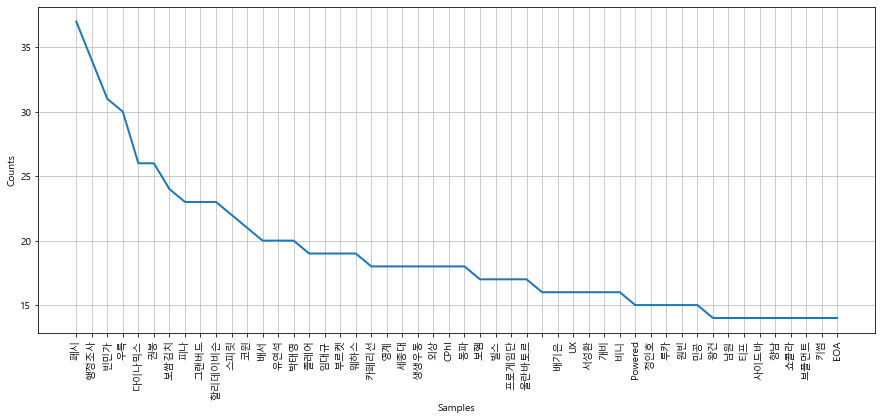

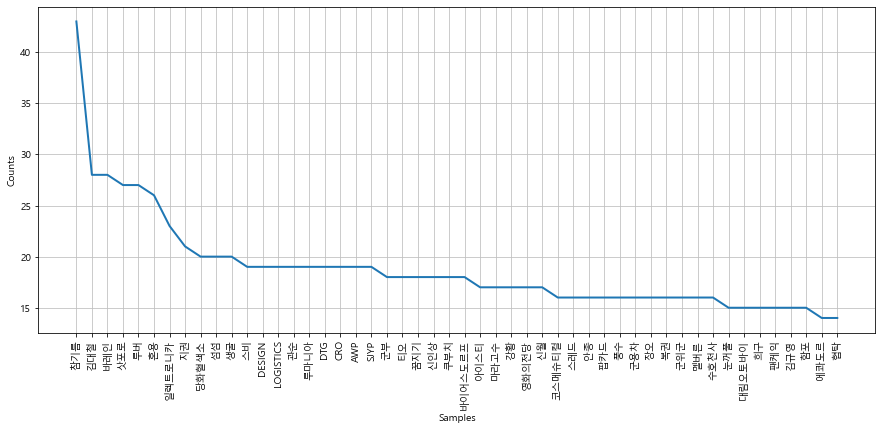

In [39]:
# 그래프에서 한글 폰트가 깨질 경우 실행
up = nltk.Text(up_only)
down = nltk.Text(down_only)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

plt.figure(figsize=(15,6))
up.plot(50)
plt.figure(figsize=(15,6))
down.plot(50)
plt.show()


In [ ]:
tokens_up = [each_word for each_word in tokens_up if each_word not in stop_words]
up = nltk.Text(tokens_up)

print(up.vocab().most_common(200))

tokens_down = [each_word for each_word in tokens_down if each_word not in stop_words]
down = nltk.Text(tokens_down)

print(down.vocab().most_common(200))

In [ ]:
# with open('without_title_text.pkl', 'wb') as f:
#     pickle.dump(title_text, f)


with open('./without_name/without_title_text.pkl', 'rb') as f:
    title_text = pickle.load(f)

In [ ]:
tokens_ko = t.morphs(title_text)
ko = nltk.Text(tokens_ko)
print("토큰 전체 개수: ", len(ko.tokens))          # 토큰 전체 개수
print("토큰 unique 개수: ", len(set(ko.tokens)))     # 토큰 unique 개수

In [ ]:
# '··',"''",'),','(-',')-','",','],','\n ',\
print(ko.vocab().most_common(200))
stop_words = ['\n',"'",'…',',','[',']','(',')','"','주','에','코스닥','특징','종목','·','장','코스피','증시','-','적',\
              '도','기술','분석','마감','‘','`','요약','가','’','의','이','오전','★','은','“','대','”','한','B','로',\
              '?','3','선','A','오후','는','5','!','"…','상','들','1','만에','제','2','…"','20','일','서','명',"'…",'기',\
              '···','10','소','등','으로','자','전','률','미','...','50','세','시','안','폭',"…'",'만','9','VI','까지',\
              '눈','더','e','량','고','인','52','성','띄네','1%','부터','다','감','을','지','4','에도','수','7','것','째',\
             '체크','기','···','중','계','관련','왜','1억원','총','내','과','젠','또','연','엔','차','굿모닝','할','8','.',\
             '보다','새','주간','전망','추천','이슈','플러스','사','개월','때','..','임','속','’…','G','나','개','원','에서',\
             '하는','이유','달','→','권','?…','단독','간','배','30','K','저','와','하','/','1조','6','두','해야','분','형',\
             '황','공','&','앞두고','보','문','이번','익','X','1억',']"','치','산','를','오','해','S','우리','그','된','준','▶',\
             '건','재','반','라','10년','초','3분','월','신','p','급','조','줄','경','했다','구','진','이어','올','발','vs','강',\
             '국','9억','1년','난','판','면','"(','`…','살','아','인데','번','텍','팜','8월','Q','메','2년','점','하고','10월',\
             'D','비','됐다','채',"]'",'보니','손','확','종','동','팔','40','타','~','9월','2100','30%','땐','말','한다','요',\
             "',",'스','…`','단','16','길','12','3억','회','될까','호','용','2조','번째','일까','듯','최']

tokens_ko = [each_word for each_word in tokens_ko if each_word not in stop_words]
ko = nltk.Text(tokens_ko)



# 그래프에서 한글 폰트가 깨질 경우 실행
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()
